# Flopy Preprocessing Steps
- import libraries
- set file paths
- load input files
    - water surface elevation raster
    - ground water domain shapefile
    - left polyline boundary for floodplain
    - right polyline boundary for floodplain
- boundary conditions
    - water surface elevation raster converted to shapefile

In [1]:
# make sure you're in virtual environment by running ".\\.venv\Scripts\activate" in terminal

In [2]:
# Import libraries
import os
import flopy
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import rasterio
import pyproj
from rasterio.crs import CRS
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.transform import from_bounds
from rasterio.mask import mask
from shapely.geometry import box, Point, Polygon, LineString
from flopy.utils.binaryfile import HeadFile
from scipy.interpolate import griddata


## Set Files to Personal Directory

Reprojected raster saved as reprojected_terrain_raster.tif
Reprojected raster saved as reprojected_water_surface_elevation_raster.tif
Cropped water surface elevation raster saved as cropped_water_surface_elevation_raster.tif


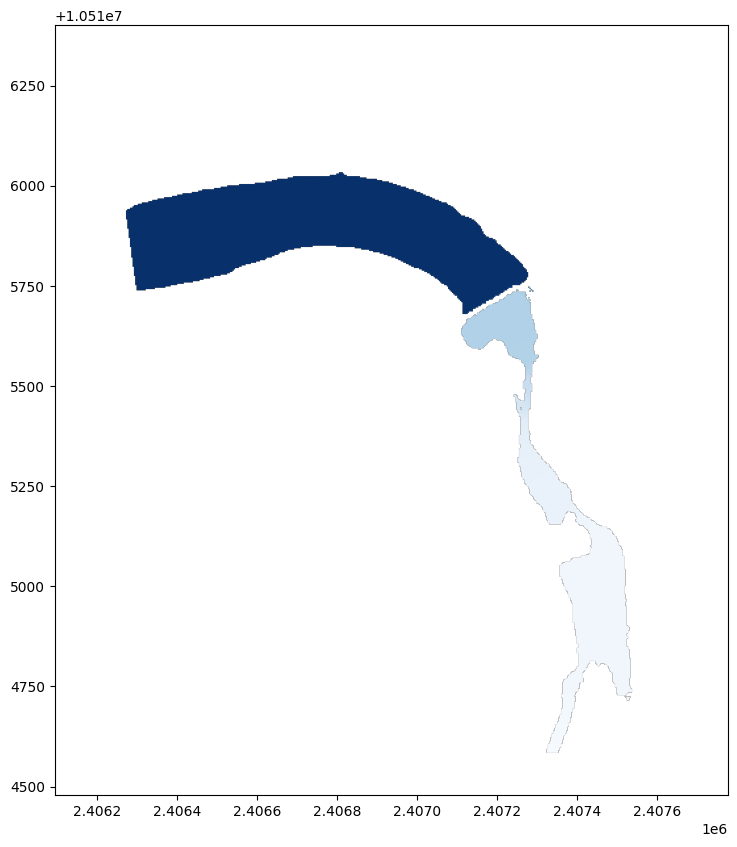

In [3]:
# Input Data
## Data Paths
water_surface_elevation_raster = r"C:\Users\u4eeevmq\Documents\Python\test_12_18_2024\CH00365\GMS\WSE (Max).USGS_1m_FebApril2018_DEM.U_USGS-3DEP_dtm_hyrdo_flattened_20240412.2041_1.tif"
terrain_elevation_raster = r"C:\Users\u4eeevmq\Documents\Python\test_12_18_2024\CH00365\GMS\BlendedTerrain.LoweredTerrain.tif"
ground_water_domain_shapefile = r"C:\Users\u4eeevmq\Documents\Python\test_12_18_2024\InputShapefiles\GWDomain.shp"
left_boundary_floodplain = r"C:\Users\u4eeevmq\Documents\Python\test_12_18_2024\InputShapefiles\L_FPL.shp"
right_boundary_floodplain = r"C:\Users\u4eeevmq\Documents\Python\test_12_18_2024\InputShapefiles\R_FPL.shp"

## Projection File Path
projection_file = r"C:\Users\u4eeevmq\Documents\Python\test_12_18_2024\CH00365\RAS\GIS_Data\102739_TX_central.prj"

## HEC-RAS CRS
hec_ras_crs = CRS.from_string(open(projection_file).read().strip())

# Load raster and shapefiles
#---------------------------------Terrain Elevation -----------------------------------------#
# Open the terrain raster
with rasterio.open(terrain_elevation_raster) as src:
    terrain_elevation = src.read(1)
    raster_transform = src.transform
    raster_crs = src.crs

    # Calculate the new transform and dimensions
    transform, width, height = calculate_default_transform(
        raster_crs, hec_ras_crs, src.width, src.height, *src.bounds
    )

    # Define metadata for the new raster
    new_meta = src.meta.copy()
    new_meta.update({
        "crs": hec_ras_crs,
        "transform": transform,
        "width": width,
        "height": height
    })

    # Define output file name
    output_raster = "reprojected_terrain_raster.tif"

    # Reproject and save
    with rasterio.open(output_raster, "w", **new_meta) as dst:
        reproject(
            source=rasterio.band(src, 1),
            destination=rasterio.band(dst, 1),
            src_transform=raster_transform,
            src_crs=raster_crs,
            dst_transform=transform,
            dst_crs=hec_ras_crs,
            resampling=Resampling.nearest
        )

print(f"Reprojected raster saved as {output_raster}")
#---------------------------------Water Surface Elevation -----------------------------------------#
# Open the input raster
with rasterio.open(water_surface_elevation_raster) as src:
    surface_elevation = src.read(1)
    raster_transform = src.transform
    raster_crs = src.crs

    # Calculate the new transform and dimensions
    transform, width, height = calculate_default_transform(
        raster_crs, hec_ras_crs, src.width, src.height, *src.bounds
    )
    
    # Define metadata for the new raster
    new_meta = src.meta.copy()
    new_meta.update({
        "crs": hec_ras_crs,
        "transform": transform,
        "width": width,
        "height": height
    })

    # Define output file name
    output_raster = "reprojected_water_surface_elevation_raster.tif"

    # Reproject and save
    with rasterio.open(output_raster, "w", **new_meta) as dst:
        reproject(
            source=rasterio.band(src, 1),
            destination=rasterio.band(dst, 1),
            src_transform=raster_transform,
            src_crs=raster_crs,
            dst_transform=transform,
            dst_crs=hec_ras_crs,
            resampling=Resampling.nearest
        )

print(f"Reprojected raster saved as {output_raster}")

# Crop the water surface elevation raster to the terrain extent
with rasterio.open(output_raster) as src:
    terrain_bounds = src.bounds
    terrain_geom = box(*terrain_bounds)

    with rasterio.open(water_surface_elevation_raster) as src:
        out_image, out_transform = mask(src, [terrain_geom], crop=True)
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })

        cropped_output_raster = "cropped_water_surface_elevation_raster.tif"
        with rasterio.open(cropped_output_raster, "w", **out_meta) as dst:
            dst.write(out_image)

print(f"Cropped water surface elevation raster saved as {cropped_output_raster}")

# Read and plot the cropped water surface elevation raster
with rasterio.open(cropped_output_raster) as src:
    cropped_surface_elevation = src.read(1)
    cropped_surface_elevation = np.ma.masked_equal(cropped_surface_elevation, src.nodata)
    cropped_surface_transform = src.transform

    plt.figure(figsize=(10, 10))
    show(cropped_surface_elevation, transform=cropped_surface_transform, cmap='Blues')
    
#---------------------------------Shapefiles -----------------------------------------#
# Load and reproject shapefiles to match the raster CRS
ground_water_domain = gpd.read_file(ground_water_domain_shapefile).to_crs(hec_ras_crs)
left_boundary = gpd.read_file(left_boundary_floodplain).to_crs(hec_ras_crs)
right_boundary = gpd.read_file(right_boundary_floodplain).to_crs(hec_ras_crs)


## Plot Terrain Elevation

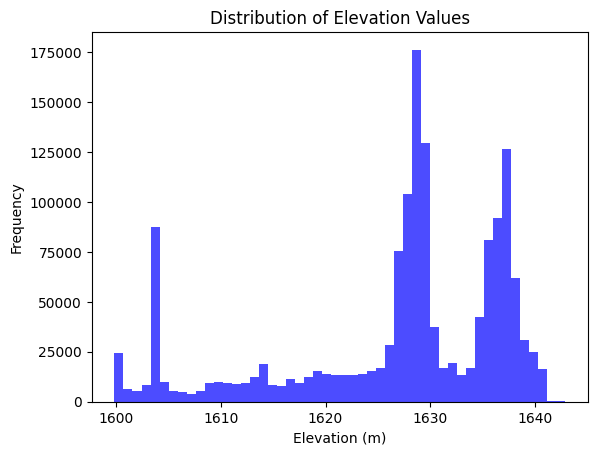

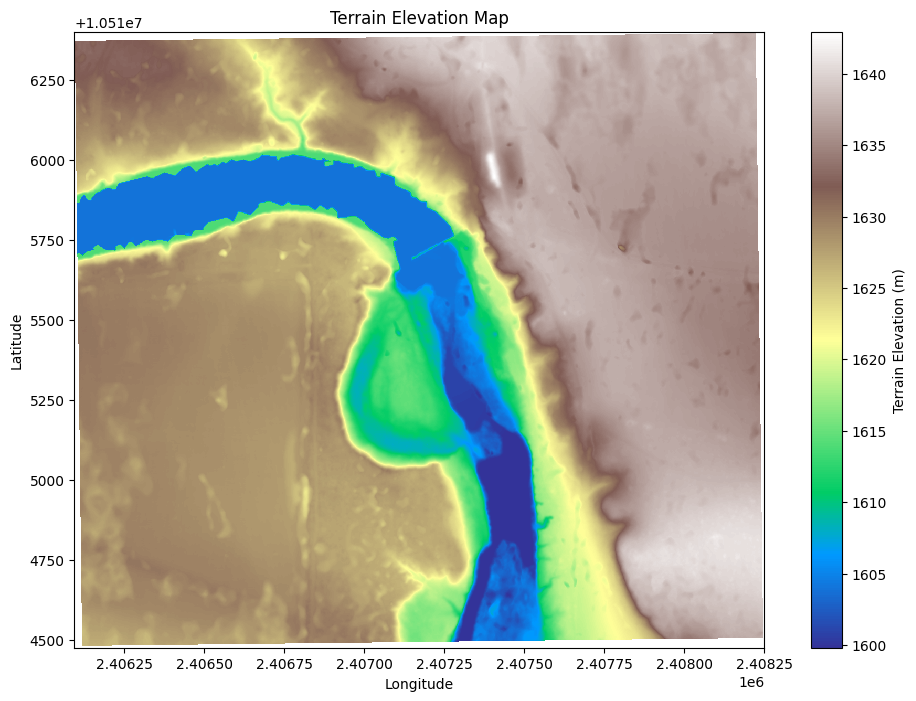

In [4]:
## Plot Terrain Elevation
reprojected_terrain_elevation_raster = r"C:\Users\u4eeevmq\Documents\Python\test_12_18_2024\reprojected_terrain_raster.tif"

# Assuming `src.nodata` is the no-data value for the raster
terrain_elevation = np.ma.masked_equal(terrain_elevation, src.nodata)

# Now you can use .compressed()
plt.hist(terrain_elevation.compressed(), bins=50, color="blue", alpha=0.7)
plt.title("Distribution of Elevation Values")
plt.xlabel("Elevation (m)")
plt.ylabel("Frequency")
plt.show()

# Map
# Load the raster file
with rasterio.open(reprojected_terrain_elevation_raster) as src:
    terrain_elevation = src.read(1)  # Read the first band
    surface_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

    # Mask no-data values if present
    terrain_elevation = np.ma.masked_equal(terrain_elevation, src.nodata)

# Plot the surface elevation
plt.figure(figsize=(12, 8))
plt.imshow(terrain_elevation, extent=surface_extent, cmap="terrain", interpolation="nearest")
plt.colorbar(label="Terrain Elevation (m)")
plt.title("Terrain Elevation Map")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

## Set up Model Simulation

In [ ]:
## Initialize Model
# Define model name and executable path
model_name = "gfw"
exe_path = r"C:\Users\u4eeevmq\Documents\Python\Flo_Py\flopy\modflowExe\mf6.exe"  # Update to your MODFLOW-6 executable path
sim_name = "gfw"
workspace = "./modflow6_workspace"

# Create the MODFLOW 6 simulation
sim = flopy.mf6.MFSimulation(sim_name=sim_name, exe_name=exe_path, sim_ws=workspace)

# Define the TDIS package (time discretization) with multiple stress periods
nper = 3  # Number of stress periods
perlen = [1.0, 10.0, 100.0]  # Length of each stress period
nstp = [1, 10, 100]  # Number of time steps in each stress period
tsmult = [1.0, 1.0, 1.0]  # Time step multiplier for each stress period
tdis = flopy.mf6.ModflowTdis(sim, time_units='DAYS', nper=nper, perioddata=list(zip(perlen, nstp, tsmult)))

# Add IMS package (solver settings)
ims = flopy.mf6.ModflowIms(
    sim,
    print_option="SUMMARY",
    outer_dvclose=1e-4,  # Increase convergence criteria for outer iterations
    outer_maximum=200,  # Increase maximum number of outer iterations
    under_relaxation="NONE",
    inner_maximum=500,  # Increase maximum number of inner iterations
    inner_dvclose=1e-4,  # Increase convergence criteria for inner iterations
    rcloserecord=1e-4,  # Increase residual convergence criteria
    linear_acceleration="BICGSTAB",  # Switch to Bi-Conjugate Gradient Stabilized method
    scaling_method="NONE",
    reordering_method="NONE",
    relaxation_factor=0.97,  # Adjust relaxation factor
)

# Create the GWF model
gwf = flopy.mf6.ModflowGwf(sim, modelname=model_name)

## Setting up Model Grid

Raster CRS: PROJCS["NAD83 / Texas Central (ftUS)",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",29.6666666666667],PARAMETER["central_meridian",-100.333333333333],PARAMETER["standard_parallel_1",30.1166666666667],PARAMETER["standard_parallel_2",31.8833333333333],PARAMETER["false_easting",2296583.33333333],PARAMETER["false_northing",9842500],UNIT["US survey foot",0.304800609601219],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Grid CRS: PROJCS["NAD83 / Texas Central (ftUS)",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Lambert_Conformal_Conic_2SP"],PA

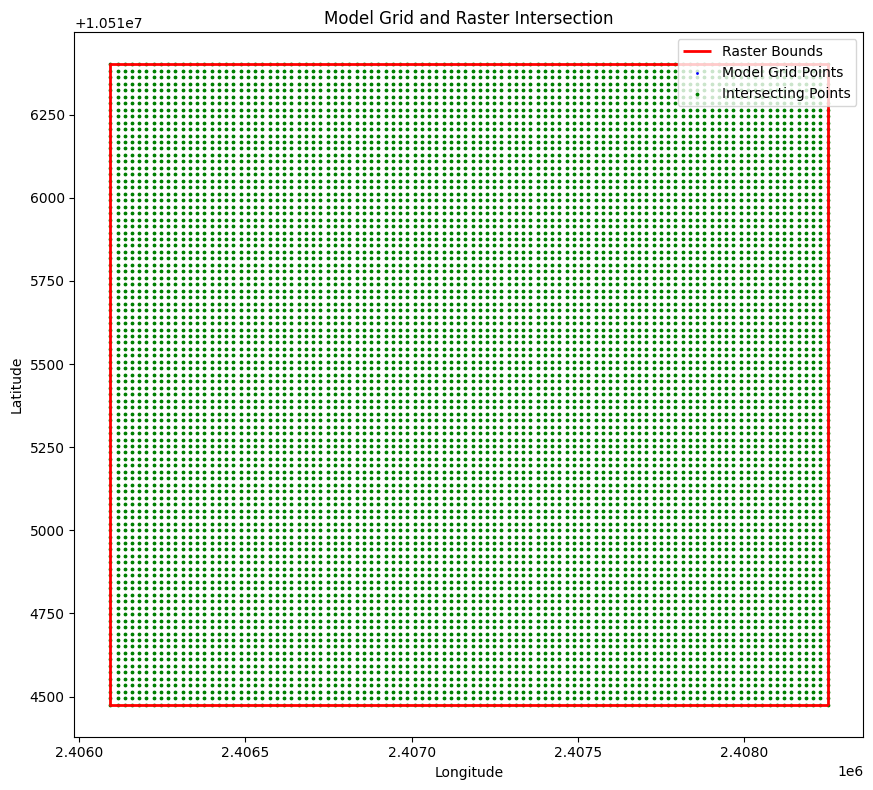

In [6]:
## Define Model Grid
# Define grid parameters
cell_size_x = cell_size_y = 5.0  # Grid cell size (5x5 feet)
nrow, ncol = 100, 100  # Grid dimensions
top = np.full((nrow, ncol), 20.0)  # Default top elevation (20 ft)
z = 0.5  # Default layer thickness (0.5 ft)
nlay = int(top.max() / z)  # Number of layers (based on default top elevation and z)

# Calculate grid cell centers
grid_x, grid_y = np.meshgrid(
    np.arange(0, ncol) * cell_size_x + (cell_size_x / 2),
    np.arange(0, nrow) * cell_size_y + (cell_size_y / 2),
)

# Convert cell centers to Points for intersection checks
grid_points = gpd.GeoDataFrame(
    {"geometry": [Point(x, y) for x, y in zip(grid_x.ravel(), grid_y.ravel())]},
    crs= hec_ras_crs,  # Replace with the actual CRS of your grid
)

# Read raster data and extract elevation values
with rasterio.open(reprojected_terrain_elevation_raster) as src:
    raster_array = src.read(1)  # Read the first band
    raster_transform = src.transform
    raster_crs = src.crs
    raster_bounds_box = box(*src.bounds)  # Create a shapely box for raster bounds
    terrain_elevation = np.ma.masked_equal(raster_array, src.nodata)  # Mask no-data values

# Create a GeoDataFrame for raster bounds
raster_bounds_gdf = gpd.GeoDataFrame(
    {"geometry": [raster_bounds_box]}, crs=hec_ras_crs
)

# Reproject grid points to match raster CRS
# Use the raster bounds to define the grid extent
minx, miny, maxx, maxy = raster_bounds_box.bounds
grid_x, grid_y = np.meshgrid(
    np.linspace(minx, maxx, ncol),
    np.linspace(miny, maxy, nrow),
)

# Recreate the grid points
grid_points = gpd.GeoDataFrame(
    {"geometry": [Point(x, y) for x, y in zip(grid_x.ravel(), grid_y.ravel())]},
    crs=raster_crs,
)

# Check intersection between grid points and raster bounds
intersecting_points = grid_points[grid_points.geometry.intersects(raster_bounds_box)]

# Debugging: Print details about the GeoDataFrames
print(f"Raster CRS: {raster_bounds_gdf.crs}")
print(f"Grid CRS: {grid_points.crs}")
print(f"Number of grid points: {len(grid_points)}")
print(f"Number of intersecting points: {len(intersecting_points)}")

# Plotting the model grid and raster intersections
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the raster bounds
raster_bounds_gdf.boundary.plot(ax=ax, color="red", linewidth=2, label="Raster Bounds")

# Plot the model grid points
grid_points.plot(ax=ax, color="blue", markersize=1, label="Model Grid Points")

# Plot the intersecting points
intersecting_points.plot(ax=ax, color="green", markersize=3, label="Intersecting Points")

# Customize the plot
ax.set_title("Model Grid and Raster Intersection")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.tight_layout()
plt.show()

## Plot Terrain Elevation and Model Grid

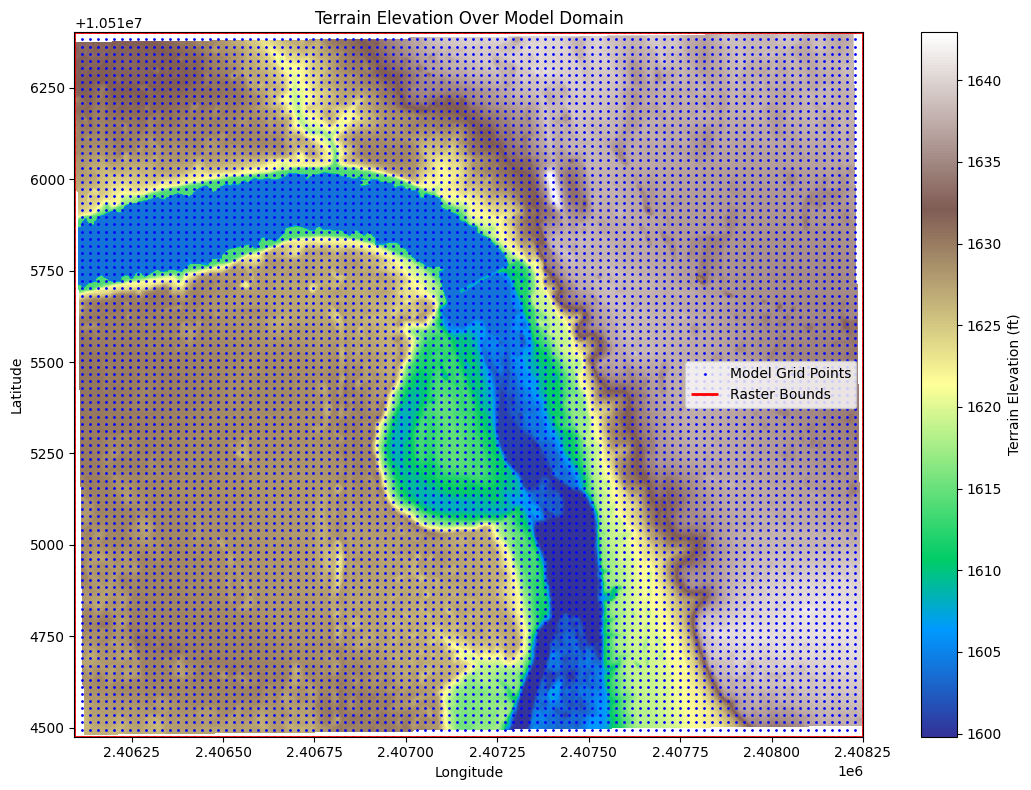

In [7]:
## Visualize Data
# Plot the raster of surface elevation over the model domain
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the raster surface elevation
plt_extent = [raster_bounds_box.bounds[0], raster_bounds_box.bounds[2],
              raster_bounds_box.bounds[1], raster_bounds_box.bounds[3]]
elevation_plot = ax.imshow(
    terrain_elevation,
    extent=plt_extent,
    cmap="terrain",
    interpolation="nearest"
)

# Add the model grid points
grid_points.plot(ax=ax, color="blue", markersize=1, label="Model Grid Points")

# Add the raster bounds for reference
raster_bounds_gdf.boundary.plot(ax=ax, color="red", linewidth=2, label="Raster Bounds")

# Add a colorbar for the raster
cbar = fig.colorbar(elevation_plot, ax=ax, label="Terrain Elevation (ft)")

# Customize the plot
ax.set_title("Terrain Elevation Over Model Domain")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.tight_layout()
plt.show()

# Set x and y origin
xmin, ymin, xmax, ymax = raster_bounds_box.bounds  # Extract bounding box extent
xorigin = xmin  # Set xorigin to the left-most boundary
yorigin = ymin  # Set yorigin to the bottom-most boundary


## Stretch Model Grid to Terrain Elevation

✅ Raster Extent: X = (2406093.5149272773, 2408251.1279889615), Y = (10514475.360625861, 10516401.62506268)
Top layer elevation (max, min): 1642.53125 1599.8125
Layer 1 top (max, min): 1642.53125 1599.875
Layer 1 botm (max, min): 1599.8125 1599.8125
Layer 2 top (max, min): 1599.8125 1599.8125
Layer 2 botm (max, min): 1599.3125 1599.3125
Layer 3 top (max, min): 1599.3125 1599.3125
Layer 3 botm (max, min): 1598.8125 1598.8125
Layer 4 top (max, min): 1598.8125 1598.8125
Layer 4 botm (max, min): 1598.3125 1598.3125
Layer 5 top (max, min): 1598.3125 1598.3125
Layer 5 botm (max, min): 1597.8125 1597.8125
Layer 6 top (max, min): 1597.8125 1597.8125
Layer 6 botm (max, min): 1597.3125 1597.3125
Layer 7 top (max, min): 1597.3125 1597.3125
Layer 7 botm (max, min): 1596.8125 1596.8125
Layer 8 top (max, min): 1596.8125 1596.8125
Layer 8 botm (max, min): 1596.3125 1596.3125
Layer 9 top (max, min): 1596.3125 1596.3125
Layer 9 botm (max, min): 1595.8125 1595.8125
Layer 10 top (max, min): 1595.8125 1595

C:\Users\u4eeevmq\AppData\Local\Temp\ipykernel_15172\1417438016.py:52: UserWarning: Warning: converting a masked element to nan.
  top[i, grid_col] = elevation_value


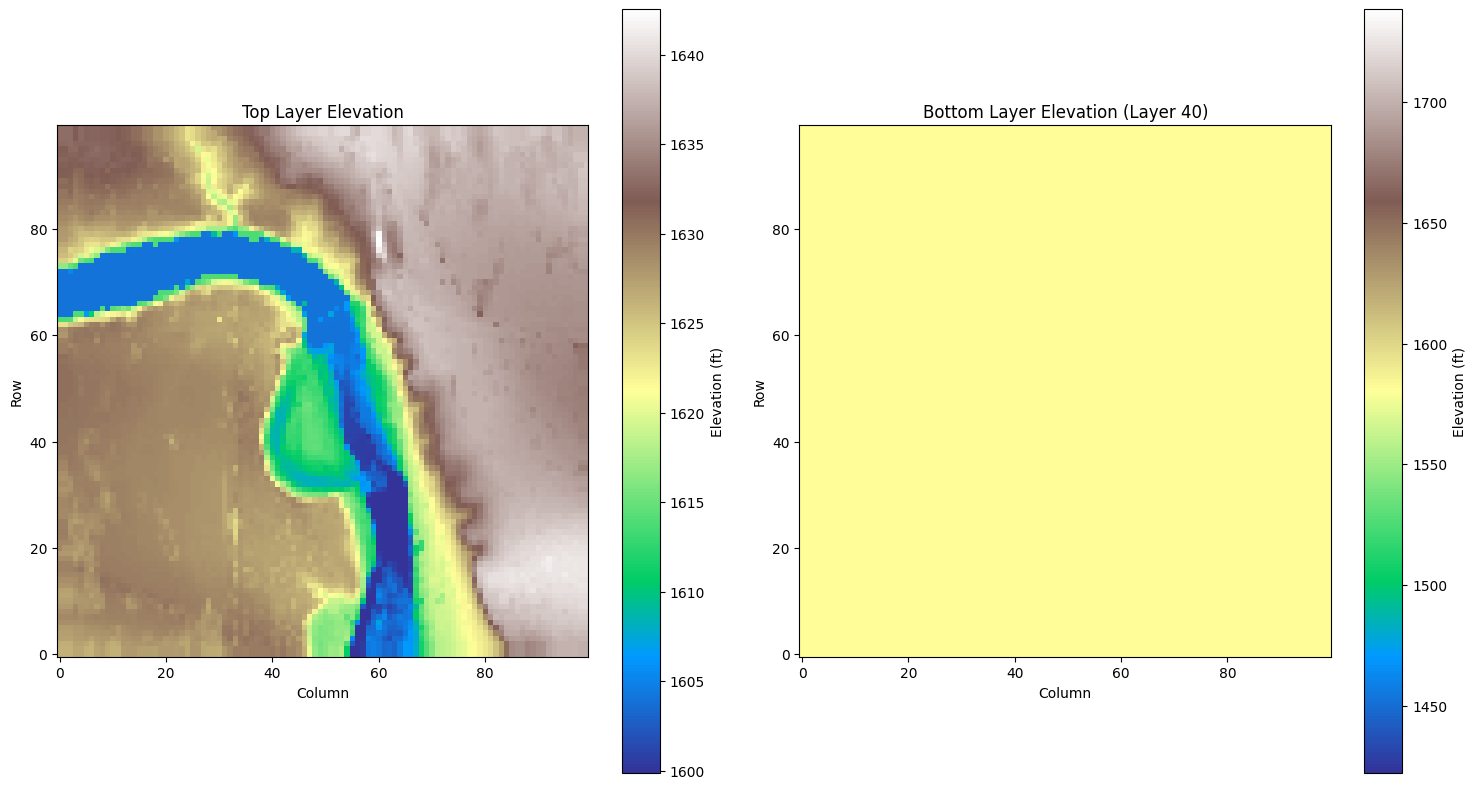

In [8]:
## Stretch Model Grid to Terrain Surface Elevation
# Extract raster extent before looping
transform = raster_transform
xmin = transform.c
ymax = transform.f
xmax = xmin + (terrain_elevation.shape[1] * transform.a)
ymin = ymax + (terrain_elevation.shape[0] * transform.e)

print(f"✅ Raster Extent: X = ({xmin}, {xmax}), Y = ({ymin}, {ymax})")

# Function to interpolate NA values
def interpolate_na(terrain):
    # Get the coordinates of the non-masked values
    valid_mask = ~terrain.mask
    valid_coords = np.array(np.nonzero(valid_mask)).T
    valid_values = terrain[valid_mask]

    # Get the coordinates of the masked values
    invalid_mask = terrain.mask
    invalid_coords = np.array(np.nonzero(invalid_mask)).T

    # Interpolate the values at the masked coordinates
    interpolated_values = griddata(valid_coords, valid_values, invalid_coords, method='nearest')

    # Fill the masked values with the interpolated values
    terrain[invalid_mask] = interpolated_values

    return terrain

# Interpolate missing values in the terrain elevation
#terrain_elevation = interpolate_na(terrain_elevation)

# Initialize the top array
top = np.full((nrow, ncol), np.nan)

# Update "top" values for each cell in the first layer based on surface elevation
for i in range(nrow):
    for grid_col in range(ncol):
        # Calculate the x, y coordinates of the cell center
        point_x = grid_x[i, grid_col]
        point_y = grid_y[i, grid_col]

        # Convert the grid cell center coordinates to raster indices
        col, row = ~raster_transform * (point_x, point_y)
        col, row = int(col), int(row)

        # Check if the indices are within raster bounds
        if 0 <= row < terrain_elevation.shape[0] and 0 <= col < terrain_elevation.shape[1]:
            elevation_value = terrain_elevation[row, col]

            # Update "top" based on the raster value
            top[i, grid_col] = elevation_value

# Interpolate any remaining NA values in the top array
top = interpolate_na(np.ma.masked_invalid(top))

## Initialize `tops` and `botm` lists
tops = [top]  # Add the top layer (surface elevation or default)
botm = []

bed_elevation = np.min(terrain_elevation) # Bed elevation is the minimum value of the cropped surface elevation

# First layer bottom is calculated from the updated "top" values
first_layer_botm = np.full_like(top, bed_elevation)  # Subtract 0.5 ft for the first layer
botm.append(first_layer_botm)

# Create remaining layers with a constant thickness of 0.5 ft
for layer in range(1, 40):  # Layers 2 to 40
    next_layer_top = botm[-1]  # The top of the current layer is the bottom of the previous layer
    next_layer_botm = next_layer_top - 0.5  # Subtract thickness from the top
    tops.append(next_layer_top)  # Add the top of the current layer
    botm.append(next_layer_botm)  # Add the bottom of the current layer

# Debugging: Check the top and bottom elevations for all layers
print("Top layer elevation (max, min):", tops[0].max(), botm[0].min())
for layer_idx in range(len(tops)):
    print(f"Layer {layer_idx + 1} top (max, min):", tops[layer_idx].max(), tops[layer_idx].min())
    print(f"Layer {layer_idx + 1} botm (max, min):", botm[layer_idx].max(), botm[layer_idx].min())

## Visualization: Plot the top and last bottom layers
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

# Plot the top layer elevation
im1 = axs[0].imshow(top, cmap="terrain", interpolation="nearest", origin="lower")  # 🔹 Ensures (0,0) is bottom-left
axs[0].set_title("Top Layer Elevation")
axs[0].set_xlabel("Column")
axs[0].set_ylabel("Row")
fig.colorbar(im1, ax=axs[0], label="Elevation (ft)")

# Plot the bottom layer elevation (Layer 40)
im2 = axs[1].imshow(botm[-1], cmap="terrain", interpolation="nearest", origin="lower")  # 🔹 Ensures bottom-left
axs[1].set_title("Bottom Layer Elevation (Layer 40)")
axs[1].set_xlabel("Column")
axs[1].set_ylabel("Row")
fig.colorbar(im2, ax=axs[1], label="Elevation (ft)")

plt.tight_layout()
plt.show()

## Define Boundary Conditions

Left Boundary Start: (2407358.236295765, 10515701.162934666), Left Boundary End: (2407570.6507961783, 10515177.034472264)
Right Boundary Start: (2407065.5187525107, 10515580.276633618), Right Boundary End: (2407188.132000717, 10515108.82005953)
Upstream Start: (2407358.236295765, 10515701.162934666), Upstream End: (2407065.5187525107, 10515580.276633618)
Downstream Start: (2407570.6507961783, 10515177.034472264), Downstream End: (2407188.132000717, 10515108.82005953)
Upstream Line: LINESTRING (2407358.236295765 10515701.162934666, 2407065.5187525107 10515580.276633618)
Downstream Line: LINESTRING (2407570.6507961783 10515177.034472264, 2407188.132000717 10515108.82005953)
✅ Upstream and Downstream boundaries created successfully!


C:\Users\u4eeevmq\AppData\Local\Temp\ipykernel_15172\3027134486.py:60: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


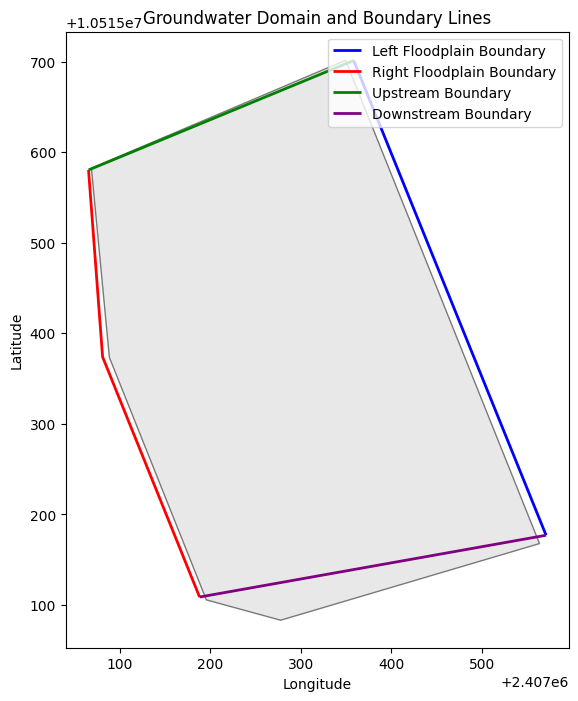

In [9]:
## Create Boundary Conditions 
# Extract the first (start) and last (end) coordinates from each boundary geometry
left_start = left_boundary.geometry.iloc[0].coords[0]  # First point
left_end = left_boundary.geometry.iloc[-1].coords[-1]  # Last point

right_start = right_boundary.geometry.iloc[0].coords[0]  # First point
right_end = right_boundary.geometry.iloc[-1].coords[-1]  # Last point

# Print start and end coordinates
print(f"Left Boundary Start: {left_start}, Left Boundary End: {left_end}")
print(f"Right Boundary Start: {right_start}, Right Boundary End: {right_end}")

# Upstream boundary coordinates (use left and right start points)
upstream_start_x, upstream_start_y = left_start  # Start of upstream from left boundary
upstream_end_x, upstream_end_y = right_start  # End of upstream from right boundary

# Downstream boundary coordinates (use left and right end points)
downstream_start_x, downstream_start_y = left_end  # Start of downstream from left boundary
downstream_end_x, downstream_end_y = right_end  # End of downstream from right boundary

# Print extracted coordinates
print(f"Upstream Start: ({upstream_start_x}, {upstream_start_y}), Upstream End: ({upstream_end_x}, {upstream_end_y})")
print(f"Downstream Start: ({downstream_start_x}, {downstream_start_y}), Downstream End: ({downstream_end_x}, {downstream_end_y})")

# Use the extracted start and end points
upstream_line = LineString([(upstream_start_x, upstream_start_y), (upstream_end_x, upstream_end_y)])
downstream_line = LineString([(downstream_start_x, downstream_start_y), (downstream_end_x, downstream_end_y)])

# Convert to GeoDataFrame
upstream_boundary = gpd.GeoDataFrame(geometry=[upstream_line], crs=left_boundary.crs)
downstream_boundary = gpd.GeoDataFrame(geometry=[downstream_line], crs=left_boundary.crs)

# Print boundary lines
print(f"Upstream Line: {upstream_line}")
print(f"Downstream Line: {downstream_line}")

# Visualize Groundwater Data
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Plot groundwater domain
if 'ground_water_domain' in locals() and not ground_water_domain.empty:
    ground_water_domain.plot(ax=ax, color="lightgray", edgecolor="black", alpha=0.5, label="Groundwater Domain")

# Plot left and right floodplain boundaries
if 'left_boundary' in locals() and not left_boundary.empty:
    left_boundary.plot(ax=ax, color="blue", linewidth=2, label="Left Floodplain Boundary")

if 'right_boundary' in locals() and not right_boundary.empty:
    right_boundary.plot(ax=ax, color="red", linewidth=2, label="Right Floodplain Boundary")

# Plot upstream and downstream boundary lines
if 'upstream_boundary' in locals() and not upstream_boundary.empty:
    upstream_boundary.plot(ax=ax, color="green", linewidth=2, label="Upstream Boundary")

if 'downstream_boundary' in locals() and not downstream_boundary.empty:
    downstream_boundary.plot(ax=ax, color="purple", linewidth=2, label="Downstream Boundary")

# Set plot labels and title
plt.legend()
plt.title("Groundwater Domain and Boundary Lines")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Check if boundaries were created successfully
if not upstream_boundary.empty and not downstream_boundary.empty:
    print("✅ Upstream and Downstream boundaries created successfully!")
else:
    print("❌ Error: One or both boundaries are empty. Check input data.")

## Create DIS Package

✅ Total Active Cells: 18920
✅ Total Inactive Cells: 381080


C:\Users\u4eeevmq\AppData\Local\Temp\ipykernel_15172\2463887707.py:20: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  grid_gdf["inside_domain"] = grid_gdf.geometry.intersects(ground_water_domain.unary_union)
C:\Users\u4eeevmq\AppData\Local\Temp\ipykernel_15172\2463887707.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


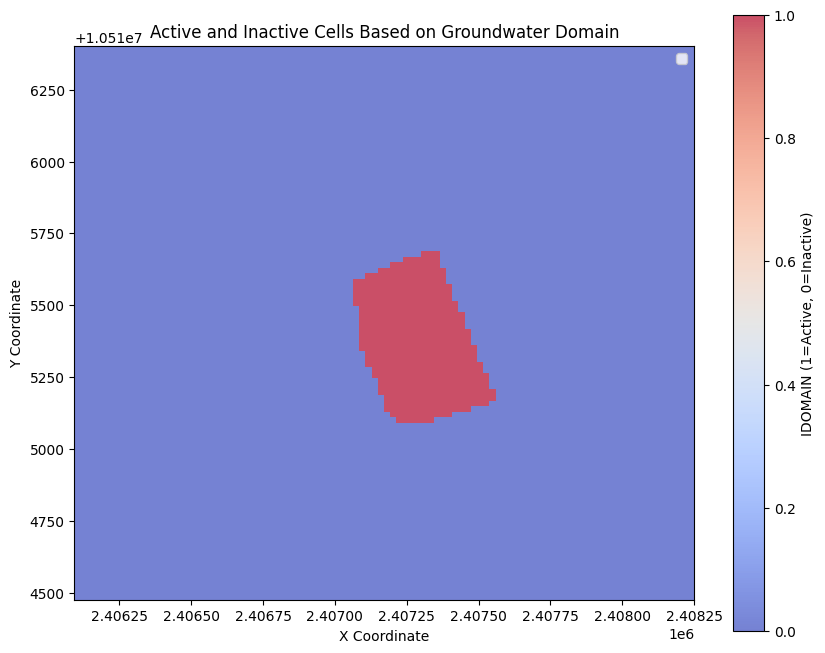

Grid Points CRS: PROJCS["NAD83 / Texas Central (ftUS)",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",29.6666666666667],PARAMETER["central_meridian",-100.333333333333],PARAMETER["standard_parallel_1",30.1166666666667],PARAMETER["standard_parallel_2",31.8833333333333],PARAMETER["false_easting",2296583.33333333],PARAMETER["false_northing",9842500],UNIT["US survey foot",0.304800609601219,AUTHORITY["EPSG","9003"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Ground Water Domain CRS: PROJCS["NAD83 / Texas Central (ftUS)",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]]

In [11]:
# -------------------- Step 1: Ensure CRS Consistency -------------------- #
if grid_points.crs != ground_water_domain.crs:
    grid_points = grid_points.to_crs(ground_water_domain.crs)

# -------------------- Step 2: Create Model Grid Cells as Polygons -------------------- #
# Define grid cell polygons based on grid resolution
grid_cells = []
for row in range(nrow):
    for col in range(ncol):
        x_min = grid_x[row, col] - (cell_size_x / 2)
        x_max = grid_x[row, col] + (cell_size_x / 2)
        y_min = grid_y[row, col] - (cell_size_y / 2)
        y_max = grid_y[row, col] + (cell_size_y / 2)
        grid_cells.append(Polygon([(x_min, y_min), (x_min, y_max), (x_max, y_max), (x_max, y_min)]))

# Convert to GeoDataFrame
grid_gdf = gpd.GeoDataFrame(geometry=grid_cells, crs=ground_water_domain.crs)

# -------------------- Step 3: Perform Spatial Join -------------------- #
grid_gdf["inside_domain"] = grid_gdf.geometry.intersects(ground_water_domain.unary_union)

# -------------------- Step 4: Initialize IDOMAIN -------------------- #
idomain = np.zeros((nlay, nrow, ncol), dtype=int)

# Assign active cells where grid intersects groundwater domain
for idx, inside in enumerate(grid_gdf["inside_domain"]):
    row, col = divmod(idx, ncol)  # Convert flat index to row, col
    if inside:
        idomain[:, row, col] = 1  # Mark as active

# Debugging: Print active/inactive cell count
print(f"✅ Total Active Cells: {np.sum(idomain == 1)}")
print(f"✅ Total Inactive Cells: {np.sum(idomain == 0)}")

# -------------------- Step 5: Visualization -------------------- #
fig, ax = plt.subplots(figsize=(10, 8))

# Plot IDOMAIN (First Layer)
im = ax.imshow(idomain[0, :, :], cmap="coolwarm", interpolation="nearest", origin="lower",
               extent=[grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()], alpha=0.7)

# Overlay Groundwater Domain
#ground_water_domain.boundary.plot(ax=ax, color="black", linewidth=2, label="Groundwater Domain")

# Axis Formatting
plt.colorbar(im, ax=ax, label="IDOMAIN (1=Active, 0=Inactive)")
plt.title("Active and Inactive Cells Based on Groundwater Domain")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend()
plt.show()

# Debugging: Check CRS Output
print("Grid Points CRS:", grid_points.crs)
print("Ground Water Domain CRS:", ground_water_domain.crs)
#print("Top Elevations 1st Layer:", tops[0])
#print("Bottom Elevations 1st Layer:", botm[0])
#print("Top Elevations:", tops)
#print("Bottom Elevations:", botm)

# Discretionize Package
dis = flopy.mf6.ModflowGwfdis(
    gwf,
    nlay=len(botm),  # Number of layers (based on `botm` list length)
    nrow=nrow,       # Number of rows in the grid
    ncol=ncol,       # Number of columns in the grid
    delr=cell_size_x,  # Cell width
    delc=cell_size_y,  # Cell height
    top=tops[0],       # List of dynamically calculated top elevation of the first layer
    botm=botm,          # List of bottom elevations for all layers
    idomain=idomain,    # List of dynamically calculated active and inactive cells in the model domain
    xorigin=xorigin,  # Assign dynamically calculated xorigin
    yorigin=yorigin   # Assign dynamically calculated yorigin
)
    
# Add initial conditions (IC package)
ic = flopy.mf6.ModflowGwfic(gwf, strt=10.0)  # Starting head set to 10 ft for all active cells

# Add hydraulic properties (NPF package)
npf = flopy.mf6.ModflowGwfnpf(
    gwf,
    k=10.0,  # Horizontal hydraulic conductivity (ft/day)
    k33=1.0,  # Vertical hydraulic conductivity (ft/day)
    save_flows=True, # Save cell-by-cell flows
    wetdry=0.1  # Threshold head value for wetting and drying cells
)

print(dis)

## Identify Boundary Cells

C:\Users\u4eeevmq\AppData\Local\Temp\ipykernel_15172\1845218765.py:15: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  grid_gdf["intersect_left_boundary"] = grid_gdf.geometry.intersects(left_boundary.unary_union)
C:\Users\u4eeevmq\AppData\Local\Temp\ipykernel_15172\1845218765.py:16: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  grid_gdf["intersect_right_boundary"] = grid_gdf.geometry.intersects(right_boundary.unary_union)
C:\Users\u4eeevmq\AppData\Local\Temp\ipykernel_15172\1845218765.py:17: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  grid_gdf["intersect_upstream_boundary"] = grid_gdf.geometry.intersects(upstream_boundary.unary_union)
C:\Users\u4eeevmq\AppData\Local\Temp\ipykernel_15172\1845218765.py:18: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  grid_gdf["in

✅ Identified 3160 model boundary cells.


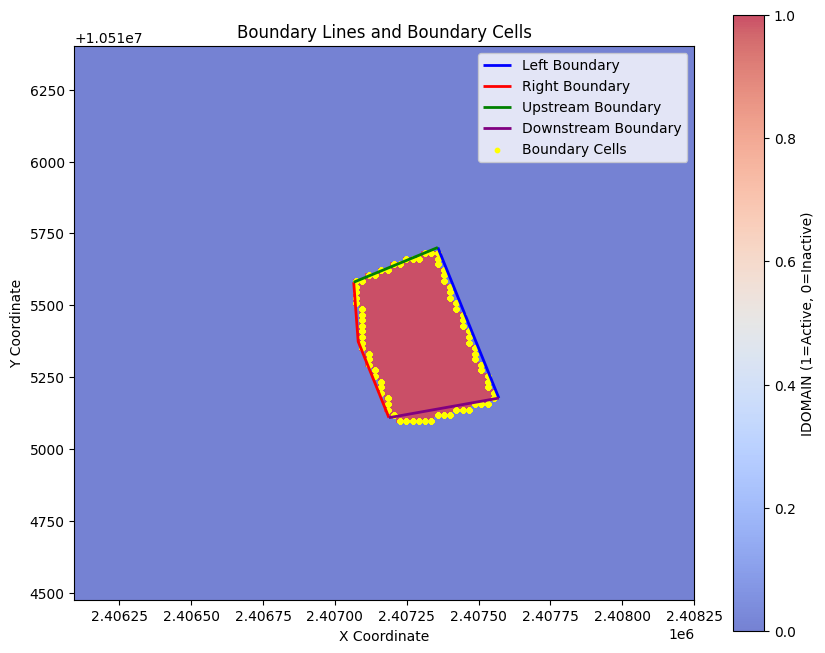

C:\Users\u4eeevmq\AppData\Local\Temp\ipykernel_15172\1845218765.py:82: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  "left": cell.geometry.distance(left_boundary.unary_union),
C:\Users\u4eeevmq\AppData\Local\Temp\ipykernel_15172\1845218765.py:83: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  "right": cell.geometry.distance(right_boundary.unary_union),
C:\Users\u4eeevmq\AppData\Local\Temp\ipykernel_15172\1845218765.py:84: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  "upstream": cell.geometry.distance(upstream_boundary.unary_union),
C:\Users\u4eeevmq\AppData\Local\Temp\ipykernel_15172\1845218765.py:85: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  "downstream": cell.geometry.distance(downstream_boundary.unary_union)
C:\Users\u4eeevmq\AppData\Local\Temp\ipykernel_

✅ Left Boundary Cells: 1040
✅ Right Boundary Cells: 920
✅ Upstream Boundary Cells: 520
✅ Downstream Boundary Cells: 680
✅ No duplicate entries found in combined boundary cells.
✅ Total Unique Boundary Cells: 3160
✅ Left Boundary Cells (First Layer): 26
✅ Right Boundary Cells (First Layer): 23
✅ Upstream Boundary Cells (First Layer): 13
✅ Downstream Boundary Cells (First Layer): 17


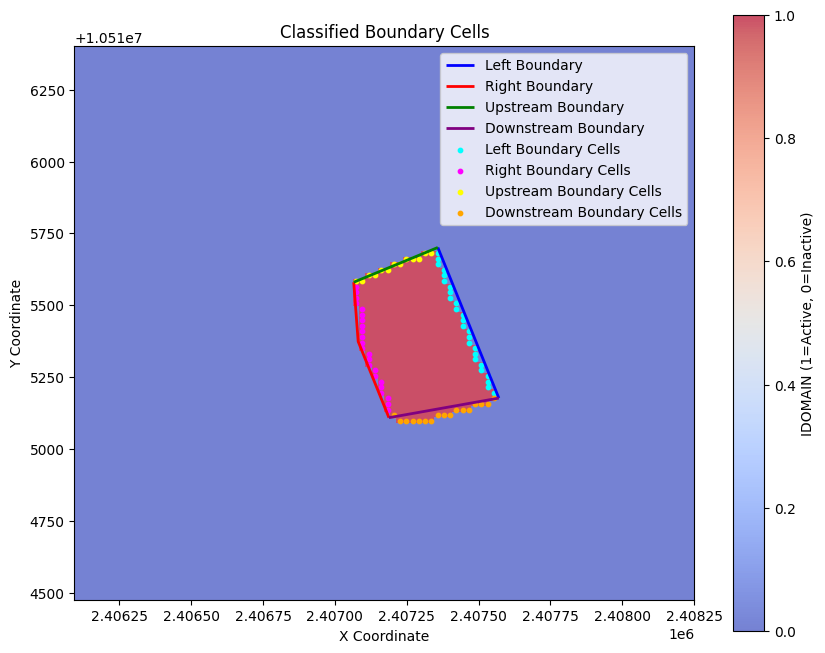

In [12]:
# -------------------- Step 1: Ensure CRS Consistency -------------------- #
if left_boundary.crs != grid_points.crs:
    left_boundary = left_boundary.to_crs(grid_points.crs)

if right_boundary.crs != grid_points.crs:
    right_boundary = right_boundary.to_crs(grid_points.crs)

if upstream_boundary.crs != grid_points.crs:
    upstream_boundary = upstream_boundary.to_crs(grid_points.crs)

if downstream_boundary.crs != grid_points.crs:
    downstream_boundary = downstream_boundary.to_crs(grid_points.crs)

# -------------------- Step 2: Perform Spatial Join -------------------- #
grid_gdf["intersect_left_boundary"] = grid_gdf.geometry.intersects(left_boundary.unary_union)
grid_gdf["intersect_right_boundary"] = grid_gdf.geometry.intersects(right_boundary.unary_union)
grid_gdf["intersect_upstream_boundary"] = grid_gdf.geometry.intersects(upstream_boundary.unary_union)
grid_gdf["intersect_downstream_boundary"] = grid_gdf.geometry.intersects(downstream_boundary.unary_union)

# -------------------- Step 3: Identify Boundary Cells -------------------- #
def identify_boundary_cells(idomain):
    boundary_cells = set()
    nlay, nrow, ncol = idomain.shape

    for row in range(nrow):
        for col in range(ncol):
            if idomain[0, row, col] == 1:
                if (
                    row > 0 and idomain[0, row - 1, col] == 0 or
                    row < nrow - 1 and idomain[0, row + 1, col] == 0 or
                    col > 0 and idomain[0, row, col - 1] == 0 or
                    col < ncol - 1 and idomain[0, row, col + 1] == 0
                ):
                    for layer in range(nlay):
                        boundary_cells.add((layer, row, col))

    print(f"✅ Identified {len(boundary_cells)} model boundary cells.")
    return list(boundary_cells)

boundary_cells = identify_boundary_cells(idomain)

# -------------------- Step 4: Plot for Debugging -------------------- #
fig, ax = plt.subplots(figsize=(10, 8))

# Plot IDOMAIN (First Layer)
im = ax.imshow(idomain[0, :, :], cmap="coolwarm", interpolation="nearest", origin="lower",
               extent=[grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()], alpha=0.7)

# Plot Boundary Lines
left_boundary.plot(ax=ax, color="blue", linewidth=2, label="Left Boundary")
right_boundary.plot(ax=ax, color="red", linewidth=2, label="Right Boundary")
upstream_boundary.plot(ax=ax, color="green", linewidth=2, label="Upstream Boundary")
downstream_boundary.plot(ax=ax, color="purple", linewidth=2, label="Downstream Boundary")

# Plot Boundary Cells
boundary_cells_coords = [(grid_x[row, col], grid_y[row, col]) for _, row, col in boundary_cells]
boundary_cells_x, boundary_cells_y = zip(*boundary_cells_coords)
ax.scatter(boundary_cells_x, boundary_cells_y, color="yellow", label="Boundary Cells", s=10)

# Axis Formatting
plt.colorbar(im, ax=ax, label="IDOMAIN (1=Active, 0=Inactive)")
plt.title("Boundary Lines and Boundary Cells")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend()
plt.show()

# -------------------- Step 5: Identify Cells with Minimum Distance to Each Boundary -------------------- #
def classify_boundary_cells(boundary_cells, grid_gdf, left_boundary, right_boundary, upstream_boundary, downstream_boundary):
    classified_cells = set()
    left_boundary_cells = []
    right_boundary_cells = []
    upstream_boundary_cells = []
    downstream_boundary_cells = []

    for layer, row, col in boundary_cells:
        if (layer, row, col) in classified_cells:
            continue  # Skip already classified cells

        cell = grid_gdf.iloc[row * ncol + col]
        distances = {
            "left": cell.geometry.distance(left_boundary.unary_union),
            "right": cell.geometry.distance(right_boundary.unary_union),
            "upstream": cell.geometry.distance(upstream_boundary.unary_union),
            "downstream": cell.geometry.distance(downstream_boundary.unary_union)
        }
        closest_boundary = min(distances, key=distances.get)
        if closest_boundary == "left":
            left_boundary_cells.append((layer, row, col))
        elif closest_boundary == "right":
            right_boundary_cells.append((layer, row, col))
        elif closest_boundary == "upstream":
            upstream_boundary_cells.append((layer, row, col))
        elif closest_boundary == "downstream":
            downstream_boundary_cells.append((layer, row, col))

        classified_cells.add((layer, row, col))  # Mark cell as classified

    return left_boundary_cells, right_boundary_cells, upstream_boundary_cells, downstream_boundary_cells

left_boundary_cells, right_boundary_cells, upstream_boundary_cells, downstream_boundary_cells = classify_boundary_cells(
    boundary_cells, grid_gdf, left_boundary, right_boundary, upstream_boundary, downstream_boundary
)

# Combine all boundary cells into a single list
all_boundary_cells = left_boundary_cells + right_boundary_cells + upstream_boundary_cells + downstream_boundary_cells

# Print the number of boundary cells identified for each boundary type
print(f"✅ Left Boundary Cells: {len(left_boundary_cells)}")
print(f"✅ Right Boundary Cells: {len(right_boundary_cells)}")
print(f"✅ Upstream Boundary Cells: {len(upstream_boundary_cells)}")
print(f"✅ Downstream Boundary Cells: {len(downstream_boundary_cells)}")

# Check for duplicates in the combined boundary cells
unique_boundary_cells = set(all_boundary_cells)
if len(unique_boundary_cells) != len(all_boundary_cells):
    print(f"❌ Found {len(all_boundary_cells) - len(unique_boundary_cells)} duplicate entries in combined boundary cells.")
else:
    print("✅ No duplicate entries found in combined boundary cells.")

# Print the total number of unique boundary cells
print(f"✅ Total Unique Boundary Cells: {len(unique_boundary_cells)}")

# Print the number of cells for each boundary type in the first layer
left_boundary_cells_first_layer = [cell for cell in left_boundary_cells if cell[0] == 0]
right_boundary_cells_first_layer = [cell for cell in right_boundary_cells if cell[0] == 0]
upstream_boundary_cells_first_layer = [cell for cell in upstream_boundary_cells if cell[0] == 0]
downstream_boundary_cells_first_layer = [cell for cell in downstream_boundary_cells if cell[0] == 0]

# Should match the amount of boundary cells identified in the first layer
print(f"✅ Left Boundary Cells (First Layer): {len(left_boundary_cells_first_layer)}")
print(f"✅ Right Boundary Cells (First Layer): {len(right_boundary_cells_first_layer)}")
print(f"✅ Upstream Boundary Cells (First Layer): {len(upstream_boundary_cells_first_layer)}")
print(f"✅ Downstream Boundary Cells (First Layer): {len(downstream_boundary_cells_first_layer)}")

# -------------------- Step 6: Plot Classified Boundary Cells -------------------- #
fig, ax = plt.subplots(figsize=(10, 8))

# Plot IDOMAIN (First Layer)
im = ax.imshow(idomain[0, :, :], cmap="coolwarm", interpolation="nearest", origin="lower",
               extent=[grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()], alpha=0.7)

# Plot Boundary Lines
left_boundary.plot(ax=ax, color="blue", linewidth=2, label="Left Boundary")
right_boundary.plot(ax=ax, color="red", linewidth=2, label="Right Boundary")
upstream_boundary.plot(ax=ax, color="green", linewidth=2, label="Upstream Boundary")
downstream_boundary.plot(ax=ax, color="purple", linewidth=2, label="Downstream Boundary")

# Plot Classified Boundary Cells
left_boundary_cells_coords = [(grid_x[row, col], grid_y[row, col]) for _, row, col in left_boundary_cells_first_layer]
right_boundary_cells_coords = [(grid_x[row, col], grid_y[row, col]) for _, row, col in right_boundary_cells_first_layer]
upstream_boundary_cells_coords = [(grid_x[row, col], grid_y[row, col]) for _, row, col in upstream_boundary_cells_first_layer]
downstream_boundary_cells_coords = [(grid_x[row, col], grid_y[row, col]) for _, row, col in downstream_boundary_cells_first_layer]

left_boundary_cells_x, left_boundary_cells_y = zip(*left_boundary_cells_coords)
right_boundary_cells_x, right_boundary_cells_y = zip(*right_boundary_cells_coords)
upstream_boundary_cells_x, upstream_boundary_cells_y = zip(*upstream_boundary_cells_coords)
downstream_boundary_cells_x, downstream_boundary_cells_y = zip(*downstream_boundary_cells_coords)

ax.scatter(left_boundary_cells_x, left_boundary_cells_y, color="cyan", label="Left Boundary Cells", s=10)
ax.scatter(right_boundary_cells_x, right_boundary_cells_y, color="magenta", label="Right Boundary Cells", s=10)
ax.scatter(upstream_boundary_cells_x, upstream_boundary_cells_y, color="yellow", label="Upstream Boundary Cells", s=10)
ax.scatter(downstream_boundary_cells_x, downstream_boundary_cells_y, color="orange", label="Downstream Boundary Cells", s=10)

# Axis Formatting
plt.colorbar(im, ax=ax, label="IDOMAIN (1=Active, 0=Inactive)")
plt.title("Classified Boundary Cells")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend()
plt.show()

## Find Bed Elevation

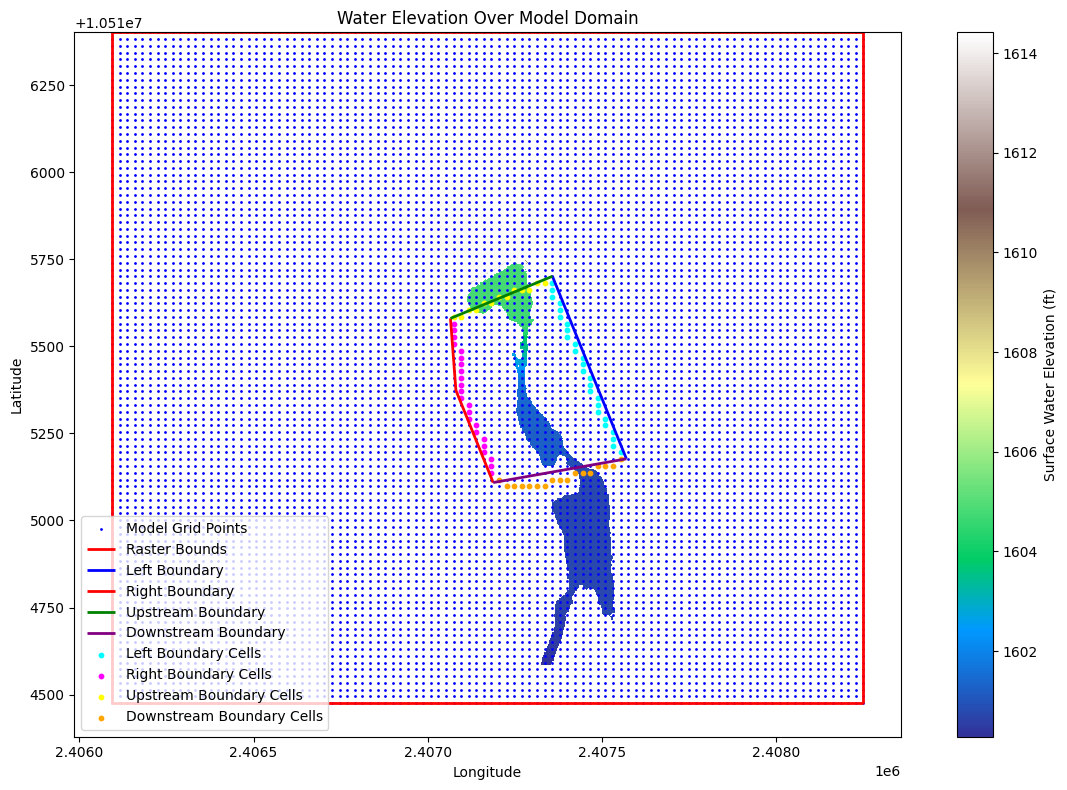

Grid points elevation values saved as grid_points_elevation.csv
Max Elevation Upstream Boundary: 1604.76611328125
Max Elevation Downstream Boundary: 1600.780517578125


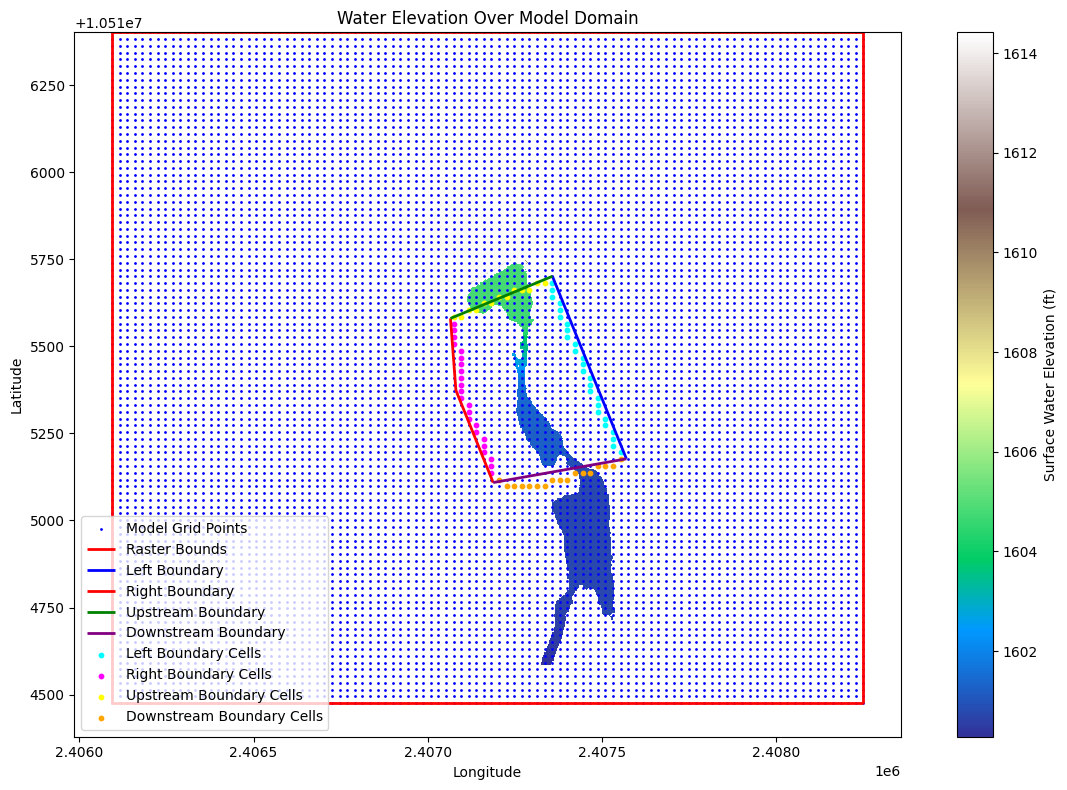

In [13]:
# -------------------- Assign Surface Water Elevations -------------------- #
# Plot
from rasterio.transform import rowcol
import pandas as pd

## Visualize Data
# Plot the raster of surface elevation over the model domain
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the raster surface elevation
plt_extent = [cropped_surface_transform[2], 
              cropped_surface_transform[2] + cropped_surface_transform[0] * cropped_surface_elevation.shape[1],
              cropped_surface_transform[5] + cropped_surface_transform[4] * cropped_surface_elevation.shape[0],
              cropped_surface_transform[5]]
elevation_plot = ax.imshow(
    cropped_surface_elevation,
    extent=plt_extent,
    cmap="terrain",
    interpolation="nearest"
)

# Add the model grid points
grid_points.plot(ax=ax, color="blue", markersize=1, label="Model Grid Points")

# Add the raster bounds for reference
raster_bounds_gdf.boundary.plot(ax=ax, color="red", linewidth=2, label="Raster Bounds")

# Add a colorbar for the raster
cbar = fig.colorbar(elevation_plot, ax=ax, label="Surface Water Elevation (ft)")

# Plot Boundary Lines
left_boundary.plot(ax=ax, color="blue", linewidth=2, label="Left Boundary")
right_boundary.plot(ax=ax, color="red", linewidth=2, label="Right Boundary")
upstream_boundary.plot(ax=ax, color="green", linewidth=2, label="Upstream Boundary")
downstream_boundary.plot(ax=ax, color="purple", linewidth=2, label="Downstream Boundary")

# Plot Classified Boundary Cells
left_boundary_cells_coords = [(grid_x[row, col], grid_y[row, col]) for _, row, col in left_boundary_cells_first_layer]
right_boundary_cells_coords = [(grid_x[row, col], grid_y[row, col]) for _, row, col in right_boundary_cells_first_layer]
upstream_boundary_cells_coords = [(grid_x[row, col], grid_y[row, col]) for _, row, col in upstream_boundary_cells_first_layer]
downstream_boundary_cells_coords = [(grid_x[row, col], grid_y[row, col]) for _, row, col in downstream_boundary_cells_first_layer]

left_boundary_cells_x, left_boundary_cells_y = zip(*left_boundary_cells_coords)
right_boundary_cells_x, right_boundary_cells_y = zip(*right_boundary_cells_coords)
upstream_boundary_cells_x, upstream_boundary_cells_y = zip(*upstream_boundary_cells_coords)
downstream_boundary_cells_x, downstream_boundary_cells_y = zip(*downstream_boundary_cells_coords)

ax.scatter(left_boundary_cells_x, left_boundary_cells_y, color="cyan", label="Left Boundary Cells", s=10)
ax.scatter(right_boundary_cells_x, right_boundary_cells_y, color="magenta", label="Right Boundary Cells", s=10)
ax.scatter(upstream_boundary_cells_x, upstream_boundary_cells_y, color="yellow", label="Upstream Boundary Cells", s=10)
ax.scatter(downstream_boundary_cells_x, downstream_boundary_cells_y, color="orange", label="Downstream Boundary Cells", s=10)

# Customize the plot
ax.set_title("Water Elevation Over Model Domain")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.tight_layout()
plt.show()

# Set NA values to a default value of bed elevation
# Define the grid points (assuming grid_points is a GeoDataFrame with 'geometry' column)
grid_points_coords = [(point.x, point.y) for point in grid_points.geometry]

# Extract elevation values at grid points
elevation_values = []
with rasterio.open(cropped_output_raster) as src:
    for x, y in grid_points_coords:
        row, col = rowcol(src.transform, x, y)
        if 0 <= row < src.height and 0 <= col < src.width:
            elevation = src.read(1)[row, col]
            elevation_values.append(elevation)
        else:
            elevation_values.append(None)  # Append None if the point is out of bounds

# Create a DataFrame with the grid points and their corresponding elevation values
grid_points_df = pd.DataFrame({
    'x': [coord[0] for coord in grid_points_coords],
    'y': [coord[1] for coord in grid_points_coords],
    'elevation': elevation_values
})

# Save the DataFrame to a CSV file
output_csv = "grid_points_elevation.csv"
grid_points_df.to_csv(output_csv, index=False)

print(f"Grid points elevation values saved as {output_csv}")

# Read the CSV file
grid_points_df = pd.read_csv(output_csv)

# Function to get max elevation for boundary cells
def get_max_elevation(boundary_cells_coords, grid_points_df):
    elevations = []
    for x, y in boundary_cells_coords:
        elevation = grid_points_df.loc[(grid_points_df['x'] == x) & (grid_points_df['y'] == y), 'elevation'].values
        if elevation.size > 0:
            elevations.append(elevation[0])
    return max(elevations) if elevations else None

# Find matching coordinates for boundary cells
upstream_boundary_cells_coords = [(grid_x[row, col], grid_y[row, col]) for _, row, col in upstream_boundary_cells_first_layer]
downstream_boundary_cells_coords = [(grid_x[row, col], grid_y[row, col]) for _, row, col in downstream_boundary_cells_first_layer]

# Calculate max surface water elevation for upstream and downstream boundary cells
max_elevation_upstream = get_max_elevation(upstream_boundary_cells_coords, grid_points_df)
max_elevation_downstream = get_max_elevation(downstream_boundary_cells_coords, grid_points_df)

# Print max elevations
print("Max Elevation Upstream Boundary:", max_elevation_upstream)
print("Max Elevation Downstream Boundary:", max_elevation_downstream)

# Plot the raster of surface elevation over the model domain
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the raster surface elevation
plt_extent = [cropped_surface_transform[2], 
              cropped_surface_transform[2] + cropped_surface_transform[0] * cropped_surface_elevation.shape[1],
              cropped_surface_transform[5] + cropped_surface_transform[4] * cropped_surface_elevation.shape[0],
              cropped_surface_transform[5]]
elevation_plot = ax.imshow(
    cropped_surface_elevation,
    extent=plt_extent,
    cmap="terrain",
    interpolation="nearest"
)

# Add the model grid points
grid_points.plot(ax=ax, color="blue", markersize=1, label="Model Grid Points")

# Add the raster bounds for reference
raster_bounds_gdf.boundary.plot(ax=ax, color="red", linewidth=2, label="Raster Bounds")

# Add a colorbar for the raster
cbar = fig.colorbar(elevation_plot, ax=ax, label="Surface Water Elevation (ft)")

# Plot Boundary Lines
left_boundary.plot(ax=ax, color="blue", linewidth=2, label="Left Boundary")
right_boundary.plot(ax=ax, color="red", linewidth=2, label="Right Boundary")
upstream_boundary.plot(ax=ax, color="green", linewidth=2, label="Upstream Boundary")
downstream_boundary.plot(ax=ax, color="purple", linewidth=2, label="Downstream Boundary")

# Plot Classified Boundary Cells
left_boundary_cells_coords = [(grid_x[row, col], grid_y[row, col]) for _, row, col in left_boundary_cells_first_layer]
right_boundary_cells_coords = [(grid_x[row, col], grid_y[row, col]) for _, row, col in right_boundary_cells_first_layer]
upstream_boundary_cells_coords = [(grid_x[row, col], grid_y[row, col]) for _, row, col in upstream_boundary_cells_first_layer]
downstream_boundary_cells_coords = [(grid_x[row, col], grid_y[row, col]) for _, row, col in downstream_boundary_cells_first_layer]

left_boundary_cells_x, left_boundary_cells_y = zip(*left_boundary_cells_coords)
right_boundary_cells_x, right_boundary_cells_y = zip(*right_boundary_cells_coords)
upstream_boundary_cells_x, upstream_boundary_cells_y = zip(*upstream_boundary_cells_coords)
downstream_boundary_cells_x, downstream_boundary_cells_y = zip(*downstream_boundary_cells_coords)

ax.scatter(left_boundary_cells_x, left_boundary_cells_y, color="cyan", label="Left Boundary Cells", s=10)
ax.scatter(right_boundary_cells_x, right_boundary_cells_y, color="magenta", label="Right Boundary Cells", s=10)
ax.scatter(upstream_boundary_cells_x, upstream_boundary_cells_y, color="yellow", label="Upstream Boundary Cells", s=10)
ax.scatter(downstream_boundary_cells_x, downstream_boundary_cells_y, color="orange", label="Downstream Boundary Cells", s=10)

# Customize the plot
ax.set_title("Water Elevation Over Model Domain")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.tight_layout()
plt.show()

## Assign Constant Head to Boundary Conditions

Left Boundary Groundwater Elevation First: 1605.26611328125
Left Boundary Groundwater Elevation Last: 1601.280517578125
Right Boundary Groundwater Elevation First: 1605.26611328125
Right Boundary Groundwater Elevation Last: 1601.280517578125
Upstream Boundary Groundwater Elevation First: 1605.26611328125
Upstream Boundary Groundwater Elevation Last: 1605.26611328125
Downstream Boundary Groundwater Elevation First: 1601.280517578125
Downstream Boundary Groundwater Elevation Last: 1601.280517578125
Left Boundary Groundwater Elevations: [np.float64(1605.26611328125), np.float64(1605.2622772892355), np.float64(1605.258441297221), np.float64(1605.2546053052063), np.float64(1605.2507693131918), np.float64(1605.2469333211773), np.float64(1605.2430973291628), np.float64(1605.239261337148), np.float64(1605.2354253451335), np.float64(1605.231589353119), np.float64(1605.2277533611045), np.float64(1605.2239173690898), np.float64(1605.2200813770753), np.float64(1605.2162453850608), np.float64(1605.

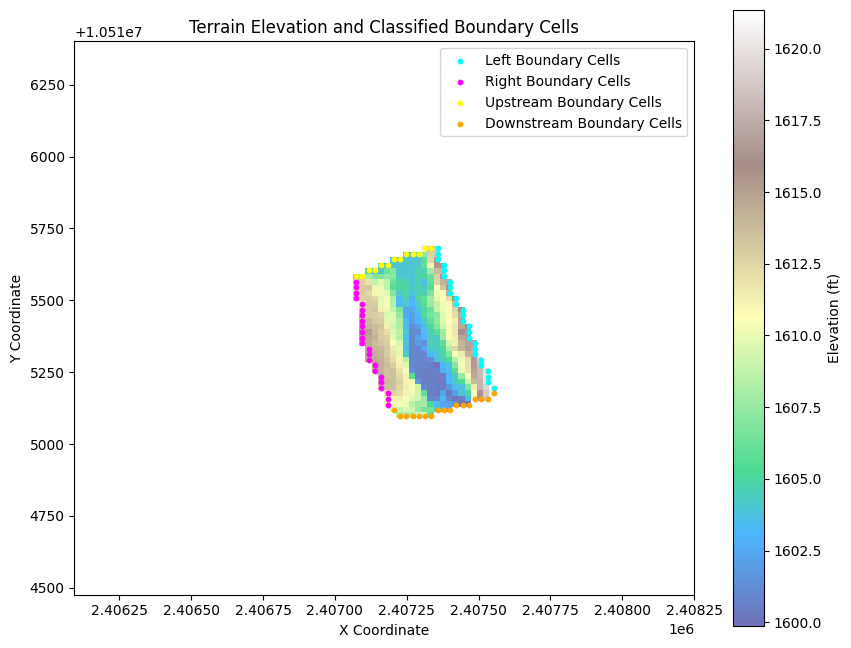

In [14]:
# Assign Ground Water Elevation to Boundary Cells
def calculate_gw_elevation(boundary_cells, top_elevation, offset):
    gw_elevation_min = []
    for cell in boundary_cells:
        layer, row, col = cell
        gw_elevation = top_elevation + offset  # Simply add the offset to the scalar top_elevation
        gw_elevation_min.append(gw_elevation)
    return gw_elevation_min

offset = 0.5  # Offset value for groundwater elevation

# Identify first and last cell for each boundary
def get_boundary_first_last(boundary_cells):
    if not boundary_cells:
        return None, None
    return boundary_cells[0], boundary_cells[-1]

left_boundary_first, left_boundary_last = get_boundary_first_last(left_boundary_cells_first_layer)
right_boundary_first, right_boundary_last = get_boundary_first_last(right_boundary_cells_first_layer)
upstream_boundary_first, upstream_boundary_last = get_boundary_first_last(upstream_boundary_cells_first_layer)
downstream_boundary_first, downstream_boundary_last = get_boundary_first_last(downstream_boundary_cells_first_layer)

# Calculate groundwater elevations for each boundary
gw_elevation_left_first = calculate_gw_elevation([left_boundary_first], max_elevation_upstream, offset)[0]
gw_elevation_left_last = calculate_gw_elevation([left_boundary_last], max_elevation_downstream, offset)[0]

gw_elevation_right_first = calculate_gw_elevation([right_boundary_first], max_elevation_upstream, offset)[0]
gw_elevation_right_last = calculate_gw_elevation([right_boundary_last], max_elevation_downstream, offset)[0]

gw_elevation_upstream_first = calculate_gw_elevation([upstream_boundary_first], max_elevation_upstream, offset)[0]
gw_elevation_upstream_last = calculate_gw_elevation([upstream_boundary_last], max_elevation_upstream, offset)[0]

gw_elevation_downstream_first = calculate_gw_elevation([downstream_boundary_first], max_elevation_downstream, offset)[0]
gw_elevation_downstream_last = calculate_gw_elevation([downstream_boundary_last], max_elevation_downstream, offset)[0]

# Debugging: Print the calculated groundwater elevations
print("Left Boundary Groundwater Elevation First:", gw_elevation_left_first)
print("Left Boundary Groundwater Elevation Last:", gw_elevation_left_last)
print("Right Boundary Groundwater Elevation First:", gw_elevation_right_first)
print("Right Boundary Groundwater Elevation Last:", gw_elevation_right_last)
print("Upstream Boundary Groundwater Elevation First:", gw_elevation_upstream_first)
print("Upstream Boundary Groundwater Elevation Last:", gw_elevation_upstream_last)
print("Downstream Boundary Groundwater Elevation First:", gw_elevation_downstream_first)
print("Downstream Boundary Groundwater Elevation Last:", gw_elevation_downstream_last)

# Interpolate Groundwater Elevation Across Boundary Cells
def interpolate_gw_elevation(boundary_cells, gw_elevation_first, gw_elevation_last):
    n = len(boundary_cells)
    if n <= 1:
        return [gw_elevation_first] * n
    interpolated_gw_elevations = []
    for i in range(n):
        interpolated_value = gw_elevation_first + (gw_elevation_last - gw_elevation_first) * i / (n - 1)
        interpolated_gw_elevations.append(interpolated_value)
    return interpolated_gw_elevations

# Interpolate groundwater elevations for each boundary
gw_elevation_left = interpolate_gw_elevation(left_boundary_cells, gw_elevation_left_first, gw_elevation_left_last)
gw_elevation_right = interpolate_gw_elevation(right_boundary_cells, gw_elevation_right_first, gw_elevation_right_last)
gw_elevation_upstream = interpolate_gw_elevation(upstream_boundary_cells, gw_elevation_upstream_first, gw_elevation_upstream_last)
gw_elevation_downstream = interpolate_gw_elevation(downstream_boundary_cells, gw_elevation_downstream_first, gw_elevation_downstream_last)

# Debugging: Print the interpolated groundwater elevations
print("Left Boundary Groundwater Elevations:", gw_elevation_left)
print("Right Boundary Groundwater Elevations:", gw_elevation_right)
print("Upstream Boundary Groundwater Elevations:", gw_elevation_upstream)
print("Downstream Boundary Groundwater Elevations:", gw_elevation_downstream)

###############################################################################
# Plot the groundwater elevation in only the active cells and highlight the boundary cells
fig, ax = plt.subplots(figsize=(10, 8))

# Plot elevation for active cells
active_cells = np.where(idomain[0, :, :] == 1)
top_active = np.ma.masked_where(idomain[0, :, :] == 0, top)
im = ax.imshow(top_active, cmap="terrain", interpolation="nearest", origin="lower",
               extent=[grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()], alpha=0.7)

# Plot Classified Boundary Cells
left_boundary_cells_coords = [(grid_x[row, col], grid_y[row, col]) for _, row, col in left_boundary_cells_first_layer]
right_boundary_cells_coords = [(grid_x[row, col], grid_y[row, col]) for _, row, col in right_boundary_cells_first_layer]
upstream_boundary_cells_coords = [(grid_x[row, col], grid_y[row, col]) for _, row, col in upstream_boundary_cells_first_layer]
downstream_boundary_cells_coords = [(grid_x[row, col], grid_y[row, col]) for _, row, col in downstream_boundary_cells_first_layer]

left_boundary_cells_x, left_boundary_cells_y = zip(*left_boundary_cells_coords)
right_boundary_cells_x, right_boundary_cells_y = zip(*right_boundary_cells_coords)
upstream_boundary_cells_x, upstream_boundary_cells_y = zip(*upstream_boundary_cells_coords)
downstream_boundary_cells_x, downstream_boundary_cells_y = zip(*downstream_boundary_cells_coords)

ax.scatter(left_boundary_cells_x, left_boundary_cells_y, color="cyan", label="Left Boundary Cells", s=10)
ax.scatter(right_boundary_cells_x, right_boundary_cells_y, color="magenta", label="Right Boundary Cells", s=10)
ax.scatter(upstream_boundary_cells_x, upstream_boundary_cells_y, color="yellow", label="Upstream Boundary Cells", s=10)
ax.scatter(downstream_boundary_cells_x, downstream_boundary_cells_y, color="orange", label="Downstream Boundary Cells", s=10)

# Axis Formatting
plt.colorbar(im, ax=ax, label="Elevation (ft)")
plt.title("Terrain Elevation and Classified Boundary Cells")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend()
plt.show()


## Create the Constant Head Boundary Package

In [15]:
# Create the CHD package
chd_data = []

# Identify boundary cells where the elevations are <= groundwater elevations
ch_left_boundary = gw_elevation_left  # Groundwater elevation list matching the left boundary cells (nlay, nrow, ncol)
ch_right_boundary = gw_elevation_right  # Groundwater elevation list matching the right boundary cells (nlay, nrow, ncol)
ch_upstream_boundary = gw_elevation_upstream  # Groundwater elevation list matching the upstream boundary cells (nlay, nrow, ncol)
ch_downstream_boundary = gw_elevation_downstream  # Groundwater elevation list matching the downstream boundary cells (nlay, nrow, ncol)

# Set to keep track of unique (nlay, nrow, ncol) coordinates
unique_chd_cells = set()
duplicate_chd_cells = set()

# Add boundary conditions for each side of the model and track duplicates

# Left Boundaries (Constant Head = ch_left_boundary)
for i, cell in enumerate(left_boundary_cells):
    nlay, nrow, ncol = cell[0], cell[1], cell[2]  # Extract nlay, nrow, ncol
    if (nlay, nrow, ncol) not in unique_chd_cells:
        chd_data.append([nlay, nrow, ncol, ch_left_boundary[i]])
        unique_chd_cells.add((nlay, nrow, ncol))  # Add to unique set
    else:
        duplicate_chd_cells.add((nlay, nrow, ncol))  # Track duplicate cells

# Right Boundaries (Constant Head = ch_right_boundary)
for i, cell in enumerate(right_boundary_cells):
    nlay, nrow, ncol = cell[0], cell[1], cell[2]  # Extract nlay, nrow, ncol
    if (nlay, nrow, ncol) not in unique_chd_cells:
        chd_data.append([nlay, nrow, ncol, ch_right_boundary[i]])
        unique_chd_cells.add((nlay, nrow, ncol))  # Add to unique set
    else:
        duplicate_chd_cells.add((nlay, nrow, ncol))  # Track duplicate cells

# Upstream Boundary (Constant Head = ch_upstream_boundary)
for i, cell in enumerate(upstream_boundary_cells):
    nlay, nrow, ncol = cell[0], cell[1], cell[2]  # Extract nlay, nrow, ncol
    if (nlay, nrow, ncol) not in unique_chd_cells:
        chd_data.append([nlay, nrow, ncol, ch_upstream_boundary[i]])
        unique_chd_cells.add((nlay, nrow, ncol))  # Add to unique set
    else:
        duplicate_chd_cells.add((nlay, nrow, ncol))  # Track duplicate cells

# Downstream Boundary (Constant Head = ch_downstream_boundary)
for i, cell in enumerate(downstream_boundary_cells):
    nlay, nrow, ncol = cell[0], cell[1], cell[2]  # Extract nlay, nrow, ncol
    if (nlay, nrow, ncol) not in unique_chd_cells:
        chd_data.append([nlay, nrow, ncol, ch_downstream_boundary[i]])
        unique_chd_cells.add((nlay, nrow, ncol))  # Add to unique set
    else:
        duplicate_chd_cells.add((nlay, nrow, ncol))  # Track duplicate cells

print(f"✅ Total Unique CHD Boundary Cells: {len(unique_chd_cells)}")
print(f"❌ Total Duplicate CHD Boundary Cells: {len(duplicate_chd_cells)}")

# Convert np.float32 to standard Python float
chd_data_converted = []

for item in chd_data:
    # Check if item[3] is a list and convert each element to float
    if isinstance(item[3], list):
        converted_head_value = [float(val) for val in item[3]]
    else:
        converted_head_value = float(item[3])
    
    converted_item = [item[0], item[1], item[2], converted_head_value]
    chd_data_converted.append(converted_item)

print(f"✅ Assigned {len(chd_data_converted)} CHD boundary cells.")

# Assign CHD Package to the model if there are valid unique boundary cells
if not chd_data_converted:
    print("❌ No CHD boundary cells assigned. Please check the input data and conditions.")
else:
    # Format the CHD values to ensure they are not in scientific notation
    formatted_chd_data = [
        [item[0], item[1], item[2], float(f"{item[3]:.2f}")]
        for item in chd_data_converted
    ]
    
    # Assuming 'gwf' is your groundwater flow model instance
    chd = flopy.mf6.ModflowGwfchd(
        gwf,
        maxbound=len(formatted_chd_data),  # Set to actual assigned CHD cells
        stress_period_data={0: formatted_chd_data},  # Apply the boundary conditions in stress period 0
        pname="CHD",
        filename=f"{model_name}.chd"
    )

    print(f"✅ Assigned {len(formatted_chd_data)} unique CHD boundary cells.")

# Optional: print the boundary cell counts
print(f"Left Boundary Cells: {len(left_boundary_cells)}")
print(f"Right Boundary Cells: {len(right_boundary_cells)}")
print(f"Upstream Boundary Cells: {len(upstream_boundary_cells)}")
print(f"Downstream Boundary Cells: {len(downstream_boundary_cells)}")

✅ Total Unique CHD Boundary Cells: 3160
❌ Total Duplicate CHD Boundary Cells: 0
✅ Assigned 3160 CHD boundary cells.
✅ Assigned 3160 unique CHD boundary cells.
Left Boundary Cells: 1040
Right Boundary Cells: 920
Upstream Boundary Cells: 520
Downstream Boundary Cells: 680


## Run Model Simulation

In [16]:
# Add Recharge Package
# Add recharge package (RCH package)
rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=0.05, save_flows= True)  # Recharge rate set to 0.05 ft/day

# Add output control (OC) package
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    budget_filerecord=f"{model_name}.cbc",
    head_filerecord=f"{model_name}.hds",
    saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    printrecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
)

# Write the MODFLOW 6 simulation files
sim.write_simulation()

# Run the MODFLOW 6 simulation
success, buff = sim.run_simulation()
if success:
    print("MODFLOW 6 simulation completed successfully!")
else:
    print("MODFLOW 6 simulation failed. Check the output for errors.")

#print(gwf.dis.top.array[1, 1])  # Example for cell (1,1,1)
#print(gwf.dis.botm.array[:, 1, 1])  # Example for the same column

# Debugging statement for the budget file
budget_file = os.path.join(workspace, f"{model_name}.cbc")
if os.path.exists(budget_file):
    if os.path.getsize(budget_file) > 0:
        print(f"Budget file '{budget_file}' exists and is not empty.")
    else:
        print(f"Budget file '{budget_file}' exists but is empty.")
else:
    print(f"Budget file '{budget_file}' does not exist.")


writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model gfw...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package chd...
    writing package rcha_0...
    writing package oc...
FloPy is using the following executable to run the model: ..\..\..\Flo_Py\flopy\modflowExe\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.5.0 05/23/2024

   MODFLOW 6 compiled Jun 21 2024 02:57:23 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update t

## Results

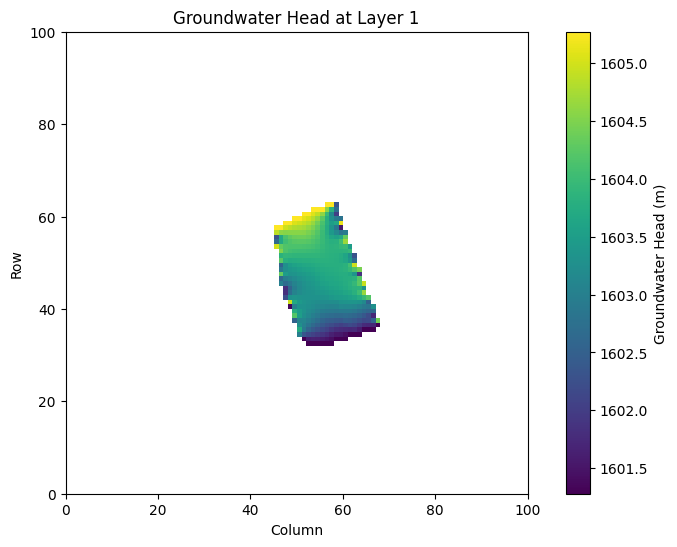

In [17]:
# Load the head file
headfile = f"{workspace}/{model_name}.hds"
hds = flopy.utils.HeadFile(headfile)
head = hds.get_data()

# Load the discretization file to access model grid information
dis = gwf.get_package("DIS")
nlay, nrow, ncol = dis.nlay.data, dis.nrow.data, dis.ncol.data

# Load the idomain array to identify active cells
idomain = dis.idomain.array # No results will be visible otherwise

# Choose the layer you want to plot, e.g., the first layer (layer 0)
layer_to_plot = 0  # You can change this to any other layer (0-based index)

# Extract the groundwater head for the specified layer (nrow, ncol)
head_layer = head[layer_to_plot, :, :]

# Mask the inactive cells in the head_layer array
head_layer_masked = np.ma.masked_where(idomain[layer_to_plot, :, :] == 0, head_layer)

# Plot the groundwater head for the chosen layer
plt.figure(figsize=(10, 6))
plt.imshow(head_layer_masked, cmap='viridis', origin='lower', extent=[0, ncol, 0, nrow])
plt.colorbar(label='Groundwater Head (m)')
plt.title(f'Groundwater Head at Layer {layer_to_plot + 1}')
plt.xlabel('Column')
plt.ylabel('Row')
plt.show()

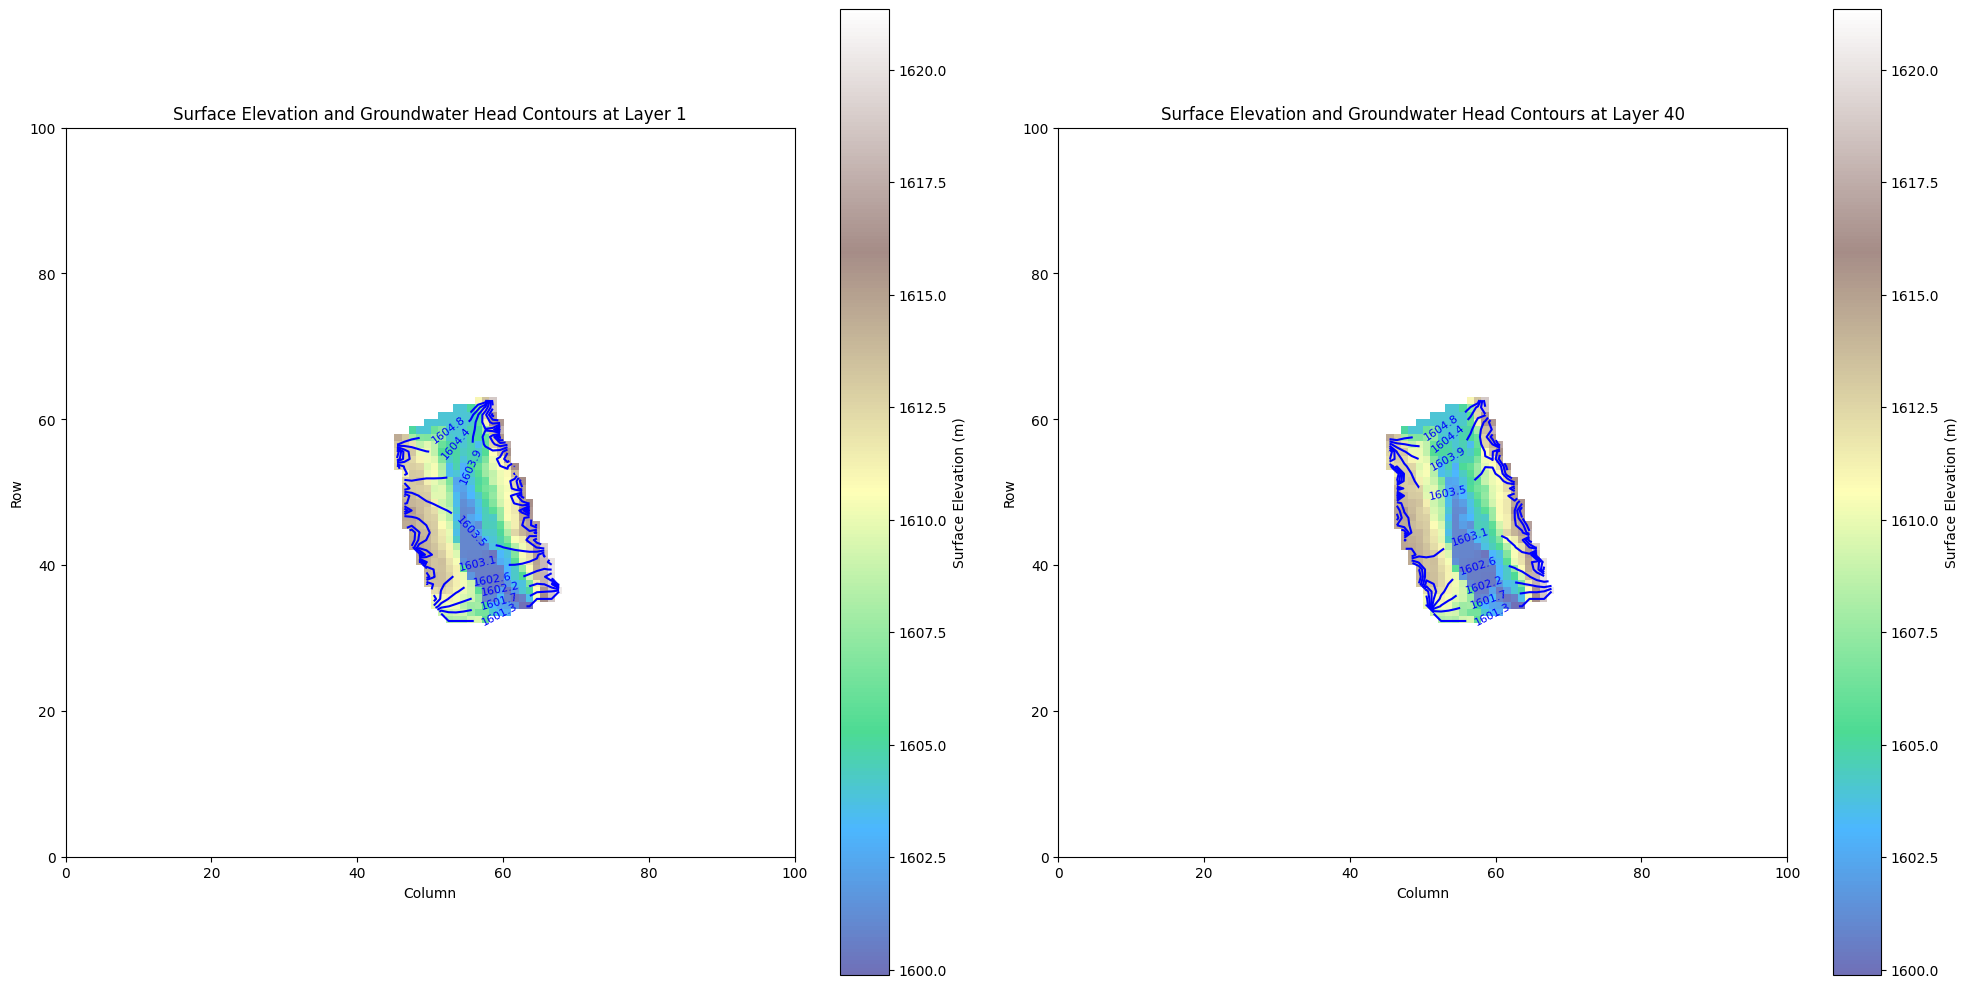

In [18]:
# Load the idomain array to identify active cells
idomain = dis.idomain.array

# Load the surface elevation data
surface_elevation = dis.top.array

# Choose the layers you want to plot, e.g., the first layer (layer 0) and the last layer
layer_to_plot_first = 0  # First layer (0-based index)
layer_to_plot_last = nlay - 1  # Last layer (0-based index)

# Extract the groundwater head for the specified layers (nrow, ncol)
head_layer_first = head[layer_to_plot_first, :, :]
head_layer_last = head[layer_to_plot_last, :, :]

# Mask the inactive cells in the head_layer arrays
head_layer_first_masked = np.ma.masked_where(idomain[layer_to_plot_first, :, :] == 0, head_layer_first)
head_layer_last_masked = np.ma.masked_where(idomain[layer_to_plot_last, :, :] == 0, head_layer_last)

# Plot the surface elevation for active cells and overlay groundwater head contours
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Plot for the first layer
top_active_first = np.ma.masked_where(idomain[layer_to_plot_first, :, :] == 0, surface_elevation)
im1 = axs[0].imshow(top_active_first, cmap="terrain", interpolation="nearest", origin="lower",
                    extent=[0, ncol, 0, nrow], alpha=0.7)
plt.colorbar(im1, ax=axs[0], label='Surface Elevation (m)')
contour_first = axs[0].contour(head_layer_first_masked, levels=np.linspace(head_layer_first_masked.min(), head_layer_first_masked.max(), 10), colors='blue', extent=[0, ncol, 0, nrow])
axs[0].clabel(contour_first, inline=True, fontsize=8, fmt='%1.1f')
axs[0].set_title(f'Surface Elevation and Groundwater Head Contours at Layer {layer_to_plot_first + 1}')
axs[0].set_xlabel('Column')
axs[0].set_ylabel('Row')

# Plot for the last layer
top_active_last = np.ma.masked_where(idomain[layer_to_plot_last, :, :] == 0, surface_elevation)
im2 = axs[1].imshow(top_active_last, cmap="terrain", interpolation="nearest", origin="lower",
                    extent=[0, ncol, 0, nrow], alpha=0.7)
plt.colorbar(im2, ax=axs[1], label='Surface Elevation (m)')
contour_last = axs[1].contour(head_layer_last_masked, levels=np.linspace(head_layer_last_masked.min(), head_layer_last_masked.max(), 10), colors='blue', extent=[0, ncol, 0, nrow])
axs[1].clabel(contour_last, inline=True, fontsize=8, fmt='%1.1f')
axs[1].set_title(f'Surface Elevation and Groundwater Head Contours at Layer {layer_to_plot_last + 1}')
axs[1].set_xlabel('Column')
axs[1].set_ylabel('Row')

plt.tight_layout()
plt.show()

## Set up MODPATH
Must be run after ModFlow 6

In [19]:
# Create MODPATH 7 object
mp = flopy.modpath.Modpath7(modelname='mp7', flowmodel=gwf, exe_name=r'C:\Users\u4eeevmq\Documents\Python\Flo_Py\flopy\modflowExe\mp7.exe', model_ws= workspace)

# Create MODPATH 7 basic package
mpbas = flopy.modpath.Modpath7Bas(mp, porosity=0.3)

# Create MODPATH 7 simulation file
mpsim = flopy.modpath.Modpath7Sim(
    mp, 
    trackingdirection='forward',  # track in forward direction
    weaksinkoption='pass_through', # particles pass through weak sinks
    weaksourceoption='pass_through', # particles pass through weak source
    budgetoutputoption='summary', # summary of budget
    referencetime=0.0, # reference time for simulation (default 0.0)
    stoptimeoption='extend', # simulation extends past the stop time if necessary
    timepointdata=[1.0, 100.0], # list of time points to track particles
    particlegroups=[]
)

# Load the idomain array to identify active cells
idomain = gwf.dis.idomain.array

# Initialize an empty list to store particle data
particle_data = []

# Iterate through the idomain array to find active cells
for k in range(idomain.shape[0]):  # Loop through layers
    for i in range(idomain.shape[1]):  # Loop through rows
        for j in range(idomain.shape[2]):  # Loop through columns
            if idomain[k, i, j] == 1:  # Check if the cell is active
                # Add particle starting location at the center of the cell
                particle_data.append((k, i, j))

# Create ParticleData object
particle_data = flopy.modpath.ParticleData(
    partlocs=particle_data, 
    structured=True, 
    localx=0.5, 
    localy=0.5, 
    localz=0.5
)

# Define particle group with the collected particle data
particlegroup = flopy.modpath.ParticleGroupNodeTemplate(
    particlegroupname='PG1', 
    particledata=particle_data
)

# Add the particle group to the MODPATH simulation
mpsim.particlegroups.append(particlegroup)

# Write MODPATH 7 input files
mp.write_input()

# Run MODPATH 7
success, buff = mp.run_model()
if not success:
    raise Exception("MODPATH did not terminate normally.")

# Post-process results (e.g., read pathline file)
pathline_file = './modflow6_workspace/mp7.mppth'
pathlines = flopy.utils.PathlineFile(pathline_file)
pathline_data = pathlines.get_alldata()

# Visualize pathlines (example using matplotlib)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for pl in pathline_data:
    ax.plot(pl['x'], pl['y'], 'b-')
plt.show()

FloPy is using the following executable to run the model: ..\..\..\Flo_Py\flopy\modflowExe\mp7.exe

MODPATH Version 7.2.001   
Program compiled Jun 21 2024 03:01:44 with IFORT compiler (ver. 20.21.7)        
 
 Improper termination of the STRESS_PERIODS block in the TDIS file. Stop.
 Press enter to terminate the program ...


: 

: 